In [1]:
# Script for training a DeepMass inference model
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

from absl import app
from absl import flags

import haiku as hk
import jax
import jax.numpy as jnp

import numpy as onp
import pickle
from functools import partial
from astropy.io import fits

from flax.metrics import tensorboard

import tensorflow as tf
import tensorflow_datasets as tfds

from jax_lensing.models.convdae import UResNet18
from jax_lensing.models.normalization import SNParamsTree
from jax_lensing.spectral import make_power_map
from jax_lensing.utils import load_dataset_deepmass
from jax_lensing.inversion import ks93, ks93inv

In [2]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
batch_size = 28
weight_dir = '/gpfswork/rech/xdy/commun/Remy2021/deepmass_sn1_cosmos_noise'
mask_path = '../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits'
train_split = "90%"
map_size = 360
dataset = 'kappatng'
sigma_gamma = 0.148

In [4]:
def forward_fn(x, is_training=False):
  model = UResNet18(n_output_channels=1)
  return model(x, condition=None, is_training=is_training)

In [5]:
model_name = "model-final.pckl"
with open(weight_dir+'/'+ model_name, 'rb') as file: 
    [params, state, sn_state] = pickle.load(file)

In [6]:
# Make the network
model = hk.without_apply_rng(hk.transform_with_state(forward_fn))

## DeepMass on the validation map

Input shear

In [8]:
mask = fits.getdata('../../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

convergence = fits.getdata('../../data/ktng/ktng_kappa360v2.fits').astype('float32')
meas_shear = fits.getdata('../../scripts/input_shear.fits').astype('float32')

mask = jnp.expand_dims(mask, -1)
masked_true_shear = meas_shear*mask

g1 = masked_true_shear[...,0]
g2 = masked_true_shear[...,1]

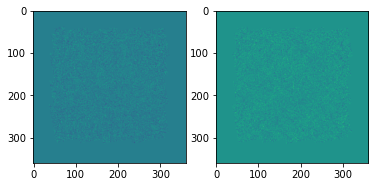

In [9]:
g1.shape
subplot(121)
imshow(g1[...])
subplot(122)
imshow(g2[...])

### KS93 before the neural network

In [10]:
ks_map = jnp.stack(ks93(g1, g2), axis=-1)
ks_map = jnp.expand_dims(ks_map,0)

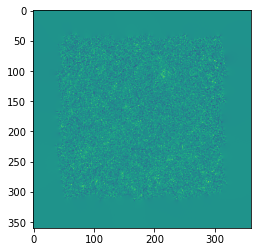

In [11]:
imshow(ks_map[0,...,0])

In [12]:
ks_map.shape

(1, 360, 360, 2)

In [13]:
res, state = model.apply(params, state, ks_map, is_training=False)

In [14]:
deepmass = res[0,...,0]

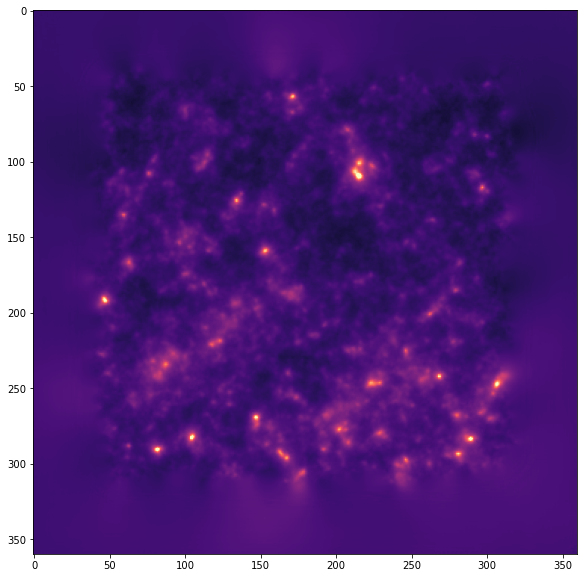

In [15]:
kwargs = dict(vmax = 0.2, vmin = -.05, cmap='magma')
figure(figsize=(10,10))
imshow(deepmass, **kwargs)

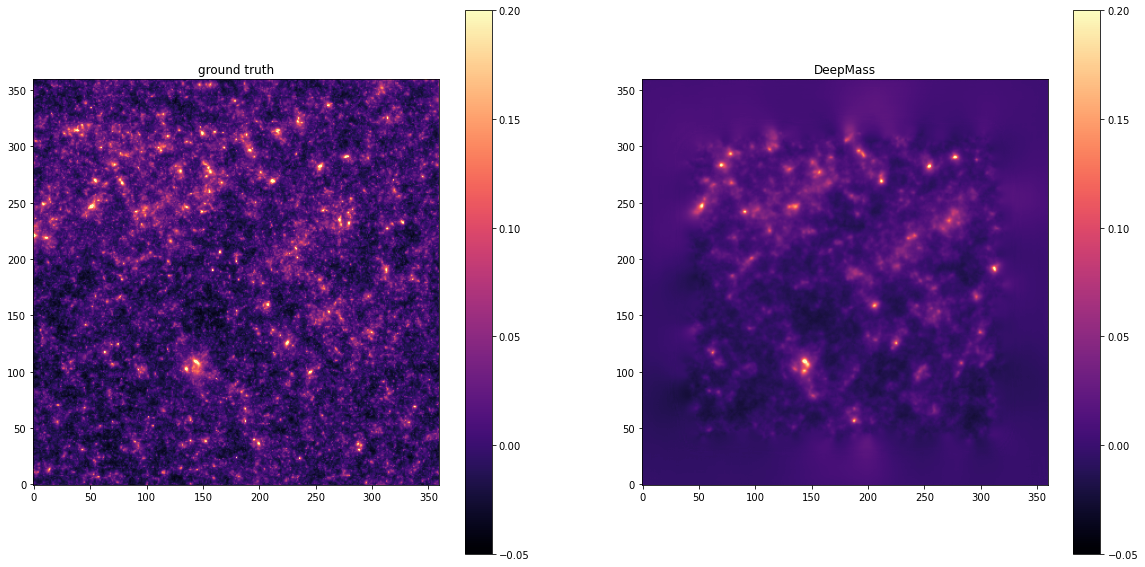

In [23]:
vmax = 0.2
vmin = -.05


figure(figsize=(20,10))
subplot(121)
imshow(convergence[...][:,::-1], origin='lower', **kwargs)
title('ground truth')
colorbar()
subplot(122)
imshow(deepmass[:,::-1], origin='lower', **kwargs)
title('DeepMass')
colorbar()

In [18]:
def rmse(a, b, mask):
    a = a - (mask*a).mean()
    b = b - (mask*b).mean()
    return(np.sqrt(np.sum(mask*(a-b)*(a-b))/np.sum(mask)))

def r(a, b, mask):
    return np.cov(mask*a, mask*b)[0,1]/np.std(mask*a)/np.std(mask*b)

In [19]:
print('RMSE', "{:.2e}".format(rmse(convergence, deepmass, mask[...,0])))
print('r', r(convergence.flatten(), deepmass.flatten(), mask.flatten()))

RMSE 2.18e-02
r 0.6769156


In [26]:
fits.writeto('./deepmass-estimate.fits', np.array(deepmass))